In [ ]:
pip install xlsxwriter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.4 MB/s eta 0:00:00


<ipython-input-16-dcaafb07afc4>:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)  # Fit the model to the training data


Mean Squared Error (MSE): 0.9941782561909919
R-squared (R²) Score: 0.929330771595472


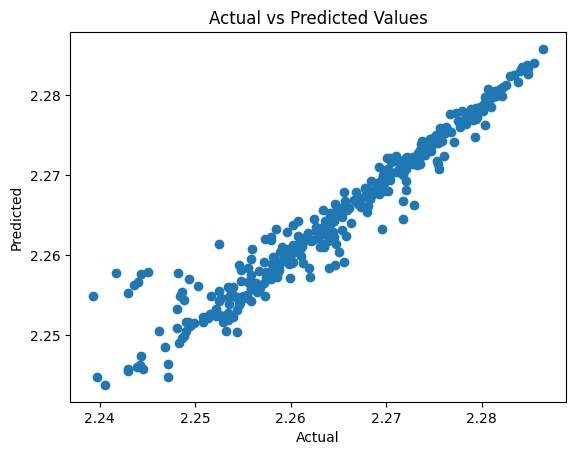

The MAPE is 0.4 %.


In [ ]:
import numpy as np  # Import the numpy library for numerical operations
import pandas as pd  # Import the pandas library for data manipulation
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting
from sklearn.model_selection import train_test_split  # Import function for splitting data into train and test sets
from sklearn.ensemble import RandomForestRegressor  # Import the RandomForestRegressor model
from sklearn.metrics import mean_squared_error, r2_score  # Import metrics for evaluating the model
import xlsxwriter  # Import xlsxwriter for writing data to Excel files

# Define a function to load and process each dataset
def load_and_process_dataset(file_path, identity_value, nrows=1000):
    dataset = pd.read_excel(file_path, nrows=nrows)  # Read the Excel file, limiting to the first nrows rows
    X = dataset.iloc[:, 1:27].values  # Extract the feature columns (columns 1 to 26)
    y = dataset.iloc[:, 27:28].values  # Extract the target column (column 27)
    identity = np.ones((len(X), 1)) * identity_value  # Create an identity column filled with the provided identity_value
    X = np.hstack((X, identity))  # Concatenate the identity column to the feature matrix
    return X, y  # Return the processed features and target

# List of file paths for each dataset
file_paths = [
    '/content/cubic.xlsx',
    '/content/hexagonal.xlsx',
    '/content/monoclinic.xlsx',
    '/content/orthorhombic.xlsx',
    '/content/tetragonal.xlsx',
    '/content/triclinic.xlsx',
    '/content/trigonal.xlsx'
]

X_list, y_list = [], []  # Initialize lists to hold features and targets

# Load and process each dataset
for i, file_path in enumerate(file_paths, 1):
    X, y = load_and_process_dataset(file_path, i)  # Load and process each dataset, assigning an identity value from 1 to 7
    X_list.append(X)  # Append the features to the list
    y_list.append(y)  # Append the targets to the list

X = np.vstack(X_list)  # Combine all feature matrices vertically
y = np.vstack(y_list)  # Combine all target vectors vertically

# Function to filter data based on a specific doping value
def filter_by_doping(X, y, doping_value):
    indices = np.where(X[:, 13] == doping_value)  # Find indices where the doping value matches the specified value
    return X[indices], y[indices]  # Return the filtered features and targets

# Filter datasets by specific doping values
X1, y1 = filter_by_doping(X, y, 1e20)  # Filter for doping value 1e20
X2, y2 = filter_by_doping(X, y, 1e19)  # Filter for doping value 1e19
X3, y3 = filter_by_doping(X, y, 1e18)  # Filter for doping value 1e18

# Further filter X3 by temperature < 1000
temperature = X3[:, 12]  # Extract temperature column
indices_4 = np.where(temperature < 1000)  # Find indices where temperature is less than 1000
X3 = X3[indices_4]  # Filter X3 using these indices
y3 = y3[indices_4]  # Filter y3 using these indices

X = np.vstack((X1, X2, X3))  # Combine the filtered datasets vertically
y = np.vstack((y1, y2, y3))  # Combine the filtered targets vertically

indices_5 = np.where(y * (10**-21) >= 1)[0]  # Filter rows where y*(10^-21) >= 1
y = np.log10(y[indices_5]**6)  # Apply the filter and transform the target variable
X = X[indices_5]  # Apply the filter to the features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # Split data into training and test sets

# Train the RandomForestRegressor model
regressor = RandomForestRegressor(
    n_estimators=391,  # Number of trees in the forest
    max_depth=100,  # Maximum depth of the tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Number of features to consider when looking for the best split
    bootstrap=False  # Whether bootstrap samples are used when building trees
)
regressor.fit(X_train, y_train)  # Fit the model to the training data
y_pred = regressor.predict(X_test)  # Predict the target values for the test set

# Calculate and print accuracy metrics
mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)  # Calculate R-squared (R²) Score
print(f"Mean Squared Error (MSE): {mse}")  # Print MSE
print(f"R-squared (R²) Score: {r2}")  # Print R² Score

# Plot actual vs predicted values
plt.scatter(y_test**(1/6), y_pred**(1/6))  # Scatter plot of actual vs predicted values
plt.xlabel('Actual')  # Set x-axis label
plt.ylabel('Predicted')  # Set y-axis label
plt.title('Actual vs Predicted Values')  # Set plot title
plt.show()  # Display the plot

# Calculate MAPE (Mean Absolute Percentage Error)
pred = 10**(y_pred**(1/6))  # Transform predicted values back to the original scale
target = 10**(y_test**(1/6))  # Transform actual values back to the original scale
total, cnt = 0, 0  # Initialize total error and count
# Loop through each prediction and calculate the absolute percentage error
for i in range(len(y_pred)):
    total += (abs(target[i] - pred[i]) / target[i]) * 100  # Accumulate absolute percentage errors
    cnt += 1  # Increment count
print(f"The MAPE is {round((total / cnt)[0], 2)} %.")  # Print the Mean Absolute Percentage Error (MAPE)

# Save the predicted results to an Excel file
workbook = xlsxwriter.Workbook('Full dataset (RF test results).xlsx')  # Create a new Excel workbook
worksheet = workbook.add_worksheet()  # Add a new worksheet to the workbook

transform_y_pred = 10**(y_pred**(1/6))  # Transform the predictions back to the original scale
transform_y_test = 10**(y_test**(1/6))  # Transform the actual values back to the original scale

actual = transform_y_test.tolist()  # Convert actual values to a list
prediction = transform_y_pred.tolist()  # Convert predicted values to a list

row = 0  # Initialize row counter
# Write the actual and predicted values to the Excel file
for act, pred in zip(actual, prediction):
    worksheet.write(row, 0, act[0])  # Write actual value to the first column
    worksheet.write(row, 1, pred)  # Write predicted value to the second column
    row += 1  # Increment row counter

workbook.close()  # Close the workbook
